<a href="https://colab.research.google.com/github/HirushikaPelagewtta/PR-Project/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install torch torchvision torchaudio scikit-learn


1) Imports & global config

In [3]:
import os, copy, json, random, time
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


2) Data (download EMNIST, split train→train/val, keep official test)

In [4]:
# Where to store/download EMNIST
EMNIST_ROOT = "./data"     # this will create ./data and download under ./data/EMNIST/...
os.makedirs(EMNIST_ROOT, exist_ok=True)

# EMNIST split you asked for: 'mnist' (10 digits)
EMNIST_SPLIT = "mnist"

# We’ll make a validation set = 15% of the official TRAIN set
VAL_FRACTION = 0.15

# ImageNet-sized inputs for pretrained backbones
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomAffine(degrees=5, translate=(0.05,0.05), shear=5, scale=(0.95,1.05)),
    transforms.Grayscale(num_output_channels=3),   # <-- convert L → RGB(3ch) while still PIL
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=3),   # <-- same here
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


# Download datasets
full_train = datasets.EMNIST(
    root=EMNIST_ROOT, split=EMNIST_SPLIT, train=True, download=True, transform=train_transform
)
test_ds = datasets.EMNIST(
    root=EMNIST_ROOT, split=EMNIST_SPLIT, train=False, download=True, transform=eval_transform
)

# Stratified split on TRAIN → train/val
y = np.array(full_train.targets) if hasattr(full_train, "targets") else np.array(full_train.labels)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_FRACTION, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros_like(y), y))

train_ds = Subset(full_train, train_idx)

# validation should use eval_transform (no aug), so re-instantiate a base train dataset with eval_transform
val_base = datasets.EMNIST(
    root=EMNIST_ROOT, split=EMNIST_SPLIT, train=True, download=False, transform=eval_transform
)
val_ds = Subset(val_base, val_idx)

# Class names and count
class_names = list(full_train.classes)
num_classes = len(class_names)
print(f"Classes ({num_classes}): {class_names}")

# DataLoaders
BATCH_SIZE = 64
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)


100%|██████████| 562M/562M [01:38<00:00, 5.70MB/s]


Classes (10): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [5]:
xb, yb = next(iter(train_loader))
print(xb.shape)  # should be [B, 3, 224, 224]


torch.Size([64, 3, 224, 224])


3) Utilities (1→3 channels, train/eval loops, plots)

In [6]:
def maybe_to_rgb(x):
    # EMNIST is [N,1,H,W]; pretrained nets expect 3 channels
    if x.shape[1] == 1:
        x = x.repeat(1, 3, 1, 1)
    return x

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        imgs = maybe_to_rgb(imgs)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds, all_targets = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        imgs = maybe_to_rgb(imgs)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

    loss = running_loss/total
    acc  = correct/total
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return loss, acc, cm, pr, rc, f1

def plot_history(hist, title):
    epochs = range(1, len(hist["train_loss"])+1)
    plt.figure()
    plt.plot(epochs, hist["train_loss"], label="train loss")
    plt.plot(epochs, hist["val_loss"],   label="val loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(title); plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, [x*100 for x in hist["val_acc"]], label="val acc (%)")
    plt.xlabel("epoch"); plt.ylabel("accuracy %"); plt.title(title); plt.legend(); plt.show()


4) Model factory (ResNet-18 / DenseNet-121)

In [7]:
def build_model(arch: str, num_classes: int, pretrained=True, freeze_backbone=False):
    arch = arch.lower()
    if arch == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
        backbone = [p for n,p in model.named_parameters() if not n.startswith("fc.")]
    elif arch == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
        in_feats = model.classifier.in_features
        model.classifier = nn.Linear(in_feats, num_classes)
        backbone = [p for n,p in model.named_parameters() if not n.startswith("classifier")]
    else:
        raise ValueError("Supported architectures: resnet18, densenet121")

    if freeze_backbone:
        for p in backbone:
            p.requires_grad = False
    return model.to(DEVICE)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


5) Fine-tuning routine (head-only → unfreeze all)

In [8]:
def finetune(arch, epochs_head=5, epochs_full=10,
             lr_head=1e-3, lr_full=2e-4, weight_decay=1e-4):
    model = build_model(arch, num_classes, pretrained=True, freeze_backbone=True)
    print(arch, "head-only trainable params:", count_trainable_params(model))

    criterion = nn.CrossEntropyLoss()

    # Phase A: train classifier head
    params_head = [p for p in model.parameters() if p.requires_grad]
    opt = optim.AdamW(params_head, lr=lr_head, weight_decay=weight_decay)
    sched = CosineAnnealingLR(opt, T_max=epochs_head)

    history = {"train_loss":[], "val_loss":[], "val_acc":[]}
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs_head+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, criterion)
        val_loss, val_acc, *_ = evaluate(model, val_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        sched.step()
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
        print(f"[{arch} | head] {epoch}/{epochs_head}  train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%")

    # Phase B: unfreeze and fine-tune all
    model.load_state_dict(best_model)
    for p in model.parameters():
        p.requires_grad = True
    print(arch, "full-train trainable params:", count_trainable_params(model))

    opt = optim.AdamW(model.parameters(), lr=lr_full, weight_decay=weight_decay)
    sched = CosineAnnealingLR(opt, T_max=epochs_full)

    for epoch in range(1, epochs_full+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, criterion)
        val_loss, val_acc, *_ = evaluate(model, val_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        sched.step()
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
        print(f"[{arch} | full] {epoch}/{epochs_full}  train_loss={tr_loss:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%")

    model.load_state_dict(best_model)
    return model, history


6) Train both SOTA models

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


resnet18 head-only trainable params: 5130
[resnet18 | head] 1/5  train_loss=0.6114  val_loss=0.3874  val_acc=89.48%
[resnet18 | head] 2/5  train_loss=0.3076  val_loss=0.2822  val_acc=92.38%
[resnet18 | head] 3/5  train_loss=0.2615  val_loss=0.2727  val_acc=92.41%
[resnet18 | head] 4/5  train_loss=0.2448  val_loss=0.2474  val_acc=93.17%
[resnet18 | head] 5/5  train_loss=0.2327  val_loss=0.2451  val_acc=93.26%
resnet18 full-train trainable params: 11181642
[resnet18 | full] 1/10  train_loss=0.0501  val_loss=0.0234  val_acc=99.28%
[resnet18 | full] 2/10  train_loss=0.0282  val_loss=0.0163  val_acc=99.59%
[resnet18 | full] 3/10  train_loss=0.0203  val_loss=0.0207  val_acc=99.40%
[resnet18 | full] 4/10  train_loss=0.0162  val_loss=0.0156  val_acc=99.63%
[resnet18 | full] 5/10  train_loss=0.0127  val_loss=0.0186  val_acc=99.50%
[resnet18 | full] 6/10  train_loss=0.0099  val_loss=0.0170  val_acc=99.53%
[resnet18 | full] 7/10  train_loss=0.0051  val_loss=0.0151  val_acc=99.62%
[resnet18 | full

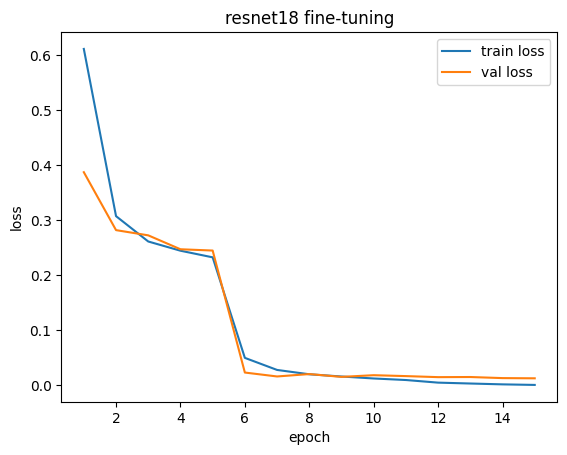

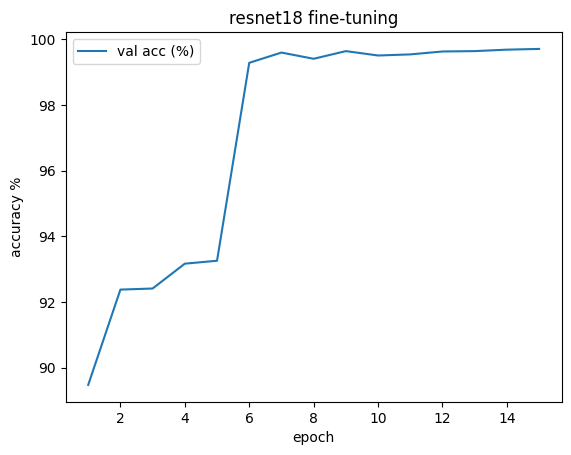

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s]


densenet121 head-only trainable params: 10250
[densenet121 | head] 1/5  train_loss=0.6503  val_loss=0.3797  val_acc=90.71%
[densenet121 | head] 2/5  train_loss=0.3272  val_loss=0.3174  val_acc=90.97%
[densenet121 | head] 3/5  train_loss=0.2819  val_loss=0.2712  val_acc=92.43%
[densenet121 | head] 4/5  train_loss=0.2550  val_loss=0.2736  val_acc=91.94%
[densenet121 | head] 5/5  train_loss=0.2458  val_loss=0.2650  val_acc=92.13%
densenet121 full-train trainable params: 6964106


In [ ]:
models_histories = {}
archs = ["resnet18", "densenet121"]

for arch in archs:
    model_ft, hist = finetune(arch,
                              epochs_head=5, epochs_full=10,
                              lr_head=1e-3, lr_full=2e-4,
                              weight_decay=1e-4)
    models_histories[arch] = {"model": model_ft, "history": hist}
    plot_history(hist, f"{arch} fine-tuning")


In [ ]:
@torch.no_grad()
def _predict_all(model, loader):
    model.eval()
    all_preds = []
    for imgs, _ in loader:
        imgs = maybe_to_rgb(imgs.to(DEVICE))
        logits = model(imgs)
        all_preds += logits.argmax(1).cpu().numpy().tolist()
    return all_preds

def evaluate_on_test(arch, model):
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, cm, pr, rc, f1 = evaluate(model, test_loader, criterion)
    print(f"[{arch}] TEST  loss={test_loss:.4f}  acc={test_acc*100:.2f}%  macro-P/R/F1= {pr:.3f}/{rc:.3f}/{f1:.3f}")
    print("\nPer-class report:\n", classification_report(
        y_true=[y for _, y in test_ds],
        y_pred=_predict_all(model, test_loader),
        target_names=[str(c) for c in class_names],
        zero_division=0))
    return {"loss": test_loss, "acc": test_acc, "cm": cm, "precision": pr, "recall": rc, "f1": f1}

results = {}
for arch in archs:
    res = evaluate_on_test(arch, models_histories[arch]["model"])
    results[arch] = res


In [ ]:
# Add your custom CNN results here (from Part 1)
custom_results = {
    "acc":       0.00,  # e.g., 0.95
    "precision": 0.00,
    "recall":    0.00,
    "f1":        0.00,
}

import pandas as pd
rows = [{"Model": "Custom CNN", "Test Acc": custom_results["acc"],
         "Precision": custom_results["precision"], "Recall": custom_results["recall"], "F1": custom_results["f1"]}]
for arch in archs:
    rows.append({"Model": arch,
                 "Test Acc": results[arch]["acc"],
                 "Precision": results[arch]["precision"],
                 "Recall": results[arch]["recall"],
                 "F1": results[arch]["f1"]})
df_compare = pd.DataFrame(rows)
df_compare


In [ ]:
os.makedirs("outputs", exist_ok=True)

def save_cm(cm, fname, labels):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(fname); plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90); plt.yticks(tick_marks, labels)
    plt.tight_layout(); plt.ylabel('True'); plt.xlabel('Predicted')
    fig.savefig(f"outputs/{fname}.png", bbox_inches='tight'); plt.close(fig)

for arch in archs:
    save_cm(results[arch]["cm"], f"{arch}_confusion_matrix", [str(c) for c in class_names])
    with open(f"outputs/{arch}_history.json","w") as f:
        json.dump(models_histories[arch]["history"], f, indent=2, default=float)

print("Saved confusion matrices and histories in ./outputs")
